## Mean Variance Investment Strategy
Use Index of representative asset classes
US Equity, Developed-Emerging Equity, Treasury, Corporate Bond are included
#### Mean-Varaiance Optimization method.
Market data from 2006 to 2022 are used to drive calculate optimal portfolio

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [4]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [5]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 3.41 seconds
[__init__] is executed in 4.55 seconds
[__init__] is executed in 3.58 seconds


In [6]:
import quantstats
from scipy.optimize import minimize

## Mean Variance Strategy Backtest for long time.

Use previous month data to build portfolio. For example, use 2022 April market data for 2022 May data.  

Investment universe are below:
|Ticker|Name|Inception|
|-----|----------------------------|---------|
|SPY|SPDR S&P 500 ETF Trust |1993-01-22|
|EFA|iShares MSCI EAFE ETF |2001-08-14|
|EEM|iShares MSCI Emerging Markets ETF |2003-04-07|
|SHY|iShares 1-3 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|IEF|iShares 7-10 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|TLT|iShares 20+ Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|LQD|iShares iBoxx Investment Grade Corporate Bond ETF|2002-07-22|

Contraint : each asset classes should be more than 3%, less than 30%

Used scipy minimize modules to find max sharpe ratio portfolio  

In [7]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [8]:
class MeanVarianceWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):


        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        # print(self.bdates[1], self.bdates[-1])
        # print(engine.date)

        date = engine.date

        target_weight = {}
        target_weight = self.compute_factor(date=date,  tickers=universe_list)

        return target_weight


    def compute_factor(self, date, tickers):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        date_1_month_lag = date - relativedelta(month=1)

        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_1_month_lag : date]
        return_df =  return_df.pct_change(1)
        return_df = return_df.fillna(1)
        
        self.return_df_dd = return_df

        def get_ret_vol_sharpe(weight):
            weight = np.array(weight)
            ret = np.sum(return_df.mean() * weight) * 252
            vol = np.sqrt(np.dot(weight.T, np.dot(return_df.cov()*252, weight)))
            # set risk free rate as 1.5%
            sharpe = (ret-0.015)/vol
            return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

        def neg_sharpe(weight):
            # to use convex optimization, change sign to minus to solve minimization problem.
            return get_ret_vol_sharpe(weight)['sharpe'] * -1

        def min_vol(weight):
            # to use convex optimization, finding minimum volatility doesn't require sign change
            return get_ret_vol_sharpe(weight)['volatility']

        # constraint : sum of weight should be less than equal to 1
        def check_sum(weight):
            #return 0 if sum of the weights is 1
            return np.sum(weight)-1

        ######################## starts here #######################-
        cons = (
        {'type':'eq',
        'fun':check_sum}
        )

        upper_bound = 0.40
        lower_bound = 0.05
        bounds = []
        initial = []
        for i in range(len(tickers)):
            bounds.append((lower_bound, upper_bound))
            initial.append(1/len(tickers))
        bounds = tuple(bounds)

        optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
        
        weight = []
        for i in range(len(tickers)):
            weight.append(optimizer.x[i])
        
        weights = {}
        i = 0
        for ticker in tickers:
            weights[ticker] = weight[i]
            i = i+1
                
        return weights 

In [9]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
# custom_universe = ['SPY','EFA','IEF','SHY']

engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
mvg = MeanVarianceWeightGenerator(engine.cache)
engine.run_backtest(target_generator=mvg, sdate=start_date, edate=end_date, transaction_cost=cost)

[__init__] is executed in 7.50 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.621 / time elapsed:23.4 ===
[run_backtest] is executed in 23.75 seconds


In [10]:
myasset = engine.asset_df.sum(axis=1)
myasset

2006-01-03    0.999000
2006-01-04    1.006022
2006-01-05    1.006290
2006-01-06    1.019676
2006-01-09    1.024109
                ...   
2022-05-25    2.598764
2022-05-26    2.619416
2022-05-27    2.646036
2022-05-31    2.635028
2022-06-01    2.620847
Length: 4132, dtype: float64

In [11]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
# custom_universe = ['SPY','EFA','IEF','SHY']

bm_engine = BacktestEngine(yfinance_list=custom_universe)
equal_weight = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal_weight, sdate=start_date, edate=end_date, transaction_cost=cost)
benchmark = bm_engine.asset_df.sum(axis=1)
benchmark

[__init__] is executed in 7.32 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.317 / time elapsed:7.8 ===
[run_backtest] is executed in 8.05 seconds


2006-01-03    0.999000
2006-01-04    1.002894
2006-01-05    1.002854
2006-01-06    1.008361
2006-01-09    1.010457
                ...   
2022-05-25    2.310684
2022-05-26    2.324136
2022-05-27    2.342992
2022-05-31    2.330067
2022-06-01    2.316652
Length: 4132, dtype: float64

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


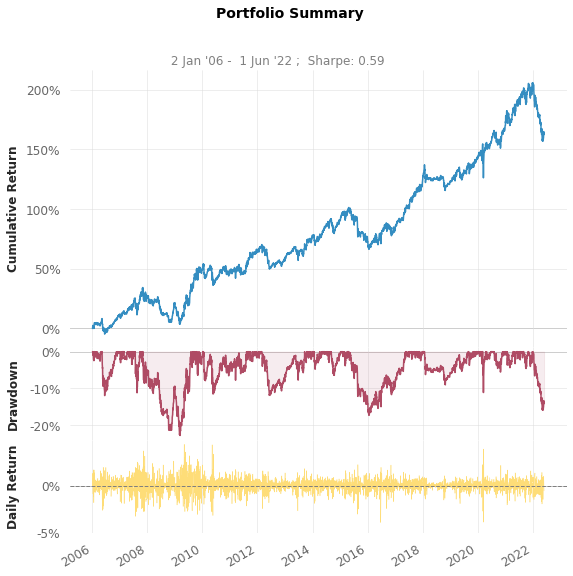

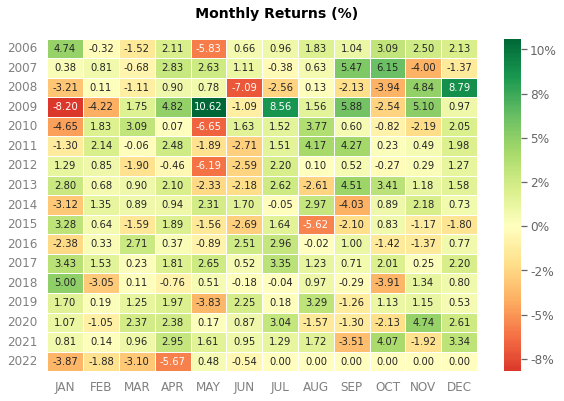

In [15]:
quantstats.reports.plots(returns=myasset, benchmark=benchmark)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          162.35%     131.9%
CAGR﹪                     6.05%       5.26%

Sharpe                     0.59        0.6
Prob. Sharpe Ratio         99.09%      99.26%
Smart Sharpe               0.56        0.58
Sortino                    0.83        0.86
Smart Sortino              0.79        0.82
Sortino/√2                 0.58        0.61
Smart Sortino/√2           0.56        0.58
Omega                      1.11        1.11

Max Drawdown               -22.89%     -26.37%
Longest DD Days            757         831
Volatility (ann.)          11.11%      9.21%
R^2                        0.46        0.46
Information Ratio          0.01        0.01
Calmar                     0.26        0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-01,2009-03-09,2009-08-03,641,-22.894837,-22.371119
2,2015-04-29,2016-01-20,2017-05-25,757,-17.395824,-16.662220
3,2022-01-05,2022-05-12,2022-06-01,147,-15.983406,-15.942700
4,2006-05-10,2006-06-13,2006-11-22,196,-11.997657,-10.877141
5,2012-02-29,2012-06-12,2013-09-18,567,-11.934516,-11.699250


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


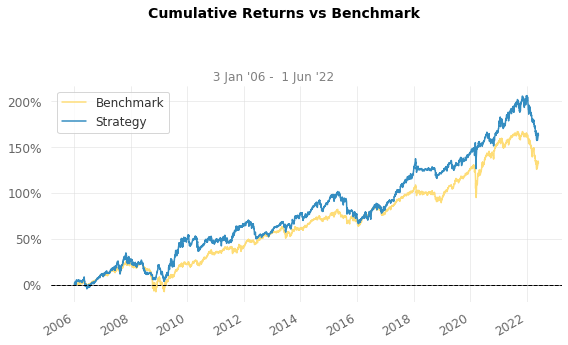

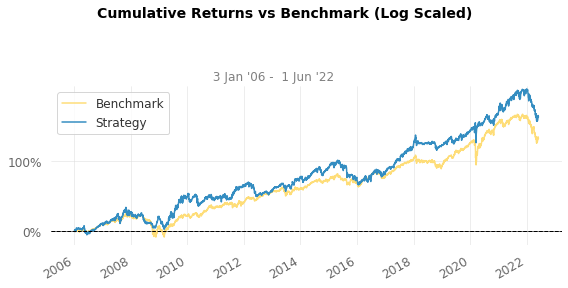

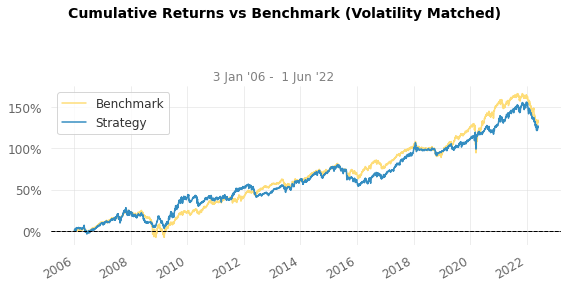

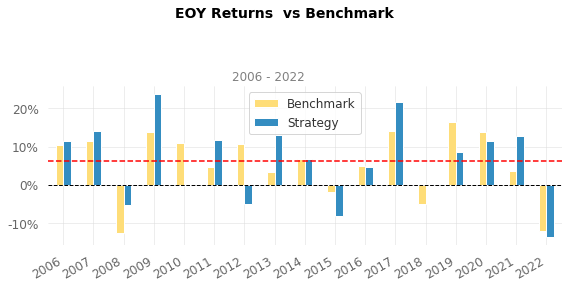

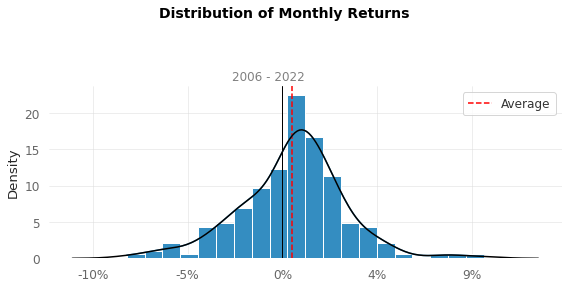

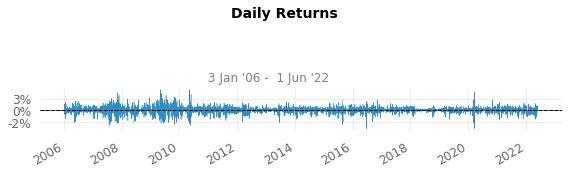

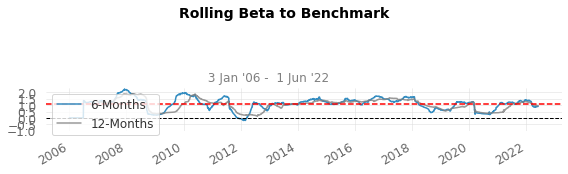

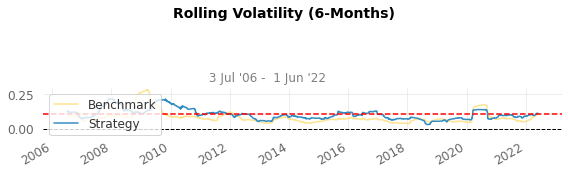

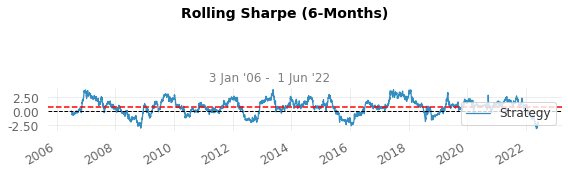

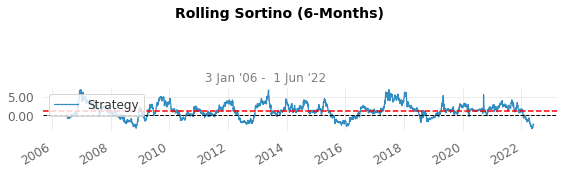

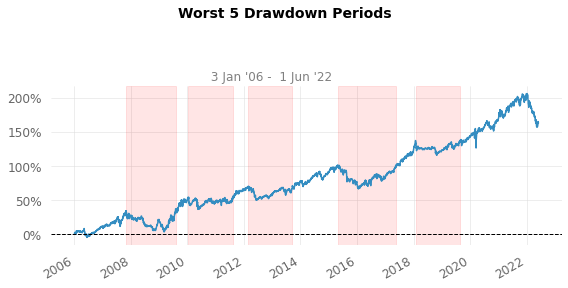

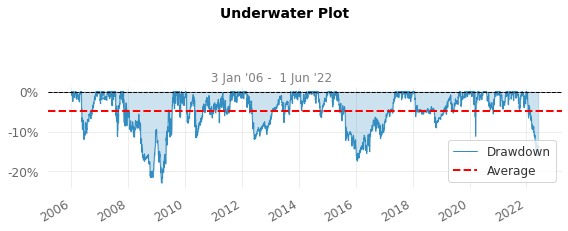

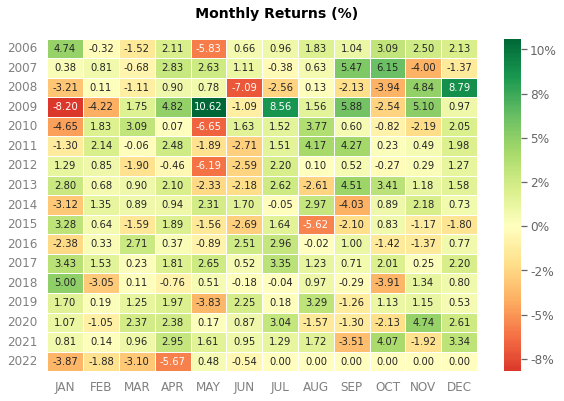

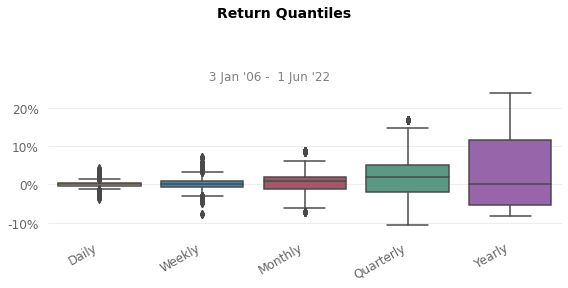

In [12]:
quantstats.reports.full(returns=myasset, benchmark=benchmark)

In [13]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,SHY,EFA,LQD,SPY,TLT,EEM,IEF
2006-01-03,0.0,0.05,0.35,0.05,0.05,0.05,0.4,0.05
2006-01-04,0.0,0.0497,0.350443,0.049651,0.049886,0.04977,0.400809,0.04974
2006-01-05,0.0,0.049644,0.348596,0.049679,0.049904,0.049697,0.402741,0.049738
2006-01-06,0.0,0.049004,0.348653,0.04895,0.049659,0.048954,0.405758,0.049021
2006-01-09,0.0,0.048798,0.347311,0.048747,0.049571,0.048774,0.407966,0.048832
...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.406719,0.050748,0.05183,0.338802,0.051407,0.048825,0.051668
2022-05-26,0.0,0.403609,0.050904,0.051435,0.342847,0.050771,0.049197,0.051236
2022-05-27,0.0,0.399644,0.051,0.051184,0.34773,0.050383,0.049265,0.050794
2022-05-31,0.0,0.400689,0.050908,0.051019,0.347223,0.049523,0.050165,0.050473


<AxesSubplot:>

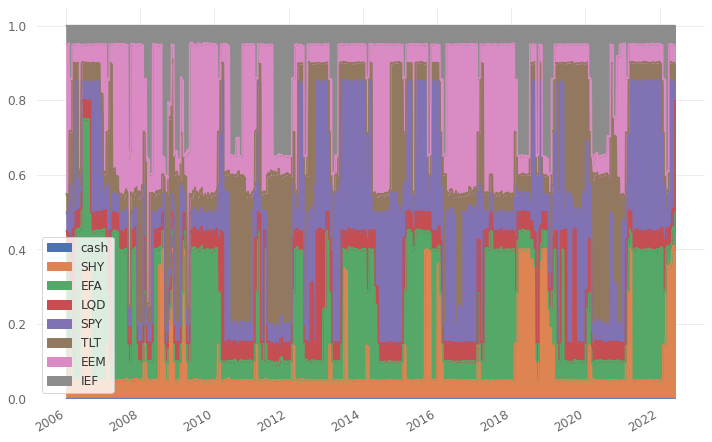

In [16]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()

## Snap shot of mean-variance portfolio using histrical data
Used market data from Jan 2006 to June 2022 to build portfolio for 2022 July. 

In [17]:
custom_universe = ['SPY','EFA','EEM','TLT','IEF','SHY','LQD']
df = pd.DataFrame()

for ticker in custom_universe:
    _df = engine.cache['index'][ticker]['closeadj'].loc[start_date:end_date]
    df =  pd.concat([df,_df],axis=1)

return_df=df/df.shift(1)
return_df=return_df.fillna(1)

In [18]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(return_df.columns)))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum(((return_df.mean()-1) * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [19]:
mv_portfolio = pd.DataFrame(index=['portfolio_#','return','volatility','sharpe'], columns=['max_return', 'max_sharpe', 'min_volatility'])

mv_portfolio.loc['portfolio_#', 'max_return'] = ret.argmax()
mv_portfolio.loc['portfolio_#', 'max_sharpe'] = sharpe.argmax()
mv_portfolio.loc['portfolio_#', 'min_volatility'] = vol.argmax()

mv_portfolio.loc['return', 'max_return'] = round(100*ret.max(),2)
mv_portfolio.loc['return', 'max_sharpe'] = round(100*ret[sharpe.argmax()],2)
mv_portfolio.loc['return', 'min_volatility'] = round(100*ret[vol.argmin()],2)

mv_portfolio.loc['volatility', 'max_return'] = round(100*vol[ret.argmax()],2)
mv_portfolio.loc['volatility', 'max_sharpe'] = round(100*vol[sharpe.argmax()],2)
mv_portfolio.loc['volatility', 'min_volatility'] =  round(100*vol.min(),2)

mv_portfolio.loc['sharpe', 'max_return'] = round(sharpe[ret.argmax()],2)
mv_portfolio.loc['sharpe', 'max_sharpe'] = round(sharpe.max(),2)
mv_portfolio.loc['sharpe', 'min_volatility'] = round(sharpe[ret.argmax()],2)

mv_result = pd.DataFrame(index=return_df.columns, columns=['max_return', 'max_sharpe', 'min_volatility'])

for i in range(len(mv_result.index)):
    mv_result['max_return'].iloc[i] = round(all_weights[ret.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['max_sharpe'].iloc[i] = round(all_weights[sharpe.argmax(),i],2)
for i in range(len(mv_result.index)):
    mv_result['min_volatility'].iloc[i] = round(all_weights[vol.argmin(),i],2)


In [20]:
mv_result

,max_return,max_sharpe,min_volatility
SPY,0.52,0.26,0.0
EFA,0.04,0.01,0.13
EEM,0.27,0.01,0.05
TLT,0.05,0.23,0.1
IEF,0.07,0.28,0.13
SHY,0.02,0.2,0.59
LQD,0.03,0.02,0.01


In [21]:
mv_portfolio

,max_return,max_sharpe,min_volatility
portfolio_#,5460,2168,893
return,9.0,5.75,3.27
volatility,18.18,5.89,4.01
sharpe,0.41,0.72,0.41


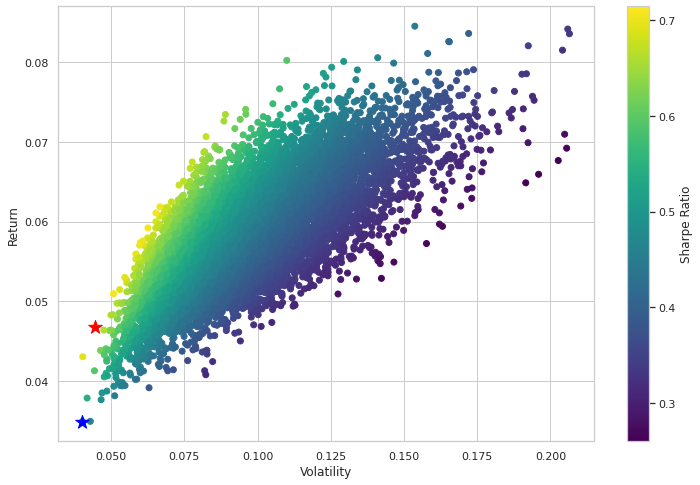

In [98]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()